# Implementation: Hidden Markov Model

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mv_normal
from scipy.misc import logsumexp
import matplotlib.mlab as mlab
from scipy.stats import chi2
from matplotlib.patches import Ellipse

We start off by loading the training data:

In [2]:
train_data = np.loadtxt('data/EMGaussian.train')
test_data = np.loadtxt('data/EMGaussian.test')

We will define a helper function that will help us compute the Gaussian pdf. This method will be used to plot the contours as well.

In [3]:
def mv_gauss(X, Y, mu, cov):
    sigma_x = np.sqrt(cov[0,0])
    sigma_y = np.sqrt(cov[1,1])
    sigma_xy = np.sqrt(cov[0,1])
    
    mu_x = mu[0]
    mu_y = mu[1]
    
    return mlab.bivariate_normal(X, Y, sigma_x, sigma_y, mu_x, mu_y, sigma_xy)

def mv_gauss_state(data, state_means, state_covs):
    
    prob_by_state = []
    
    for mu, sigma in zip(state_means, state_covs):
        prob_by_state.append(mv_normal.pdf(x=data, cov=sigma, mean=mu))
    return np.column_stack(prob_by_state)

# Implementation of the $\alpha$ and $\beta$ recursions

We start by implementing the alpha-beta recursion. We will be using the log-sum-exp trick to avoid underflows. Thus we will compute:

$\log(\alpha_t(z_t)) = \log \bigg( \sum_{z_t} \exp \bigg(\log p(x_t | z_t) + \log p(z_t | z_{t-1}) + \log \alpha_{t-1}(z_{t-1}) \bigg) \bigg)$

Which can be rewritten as:

$\log(\alpha_t(z_t)) = \log \bigg( \sum_{z_t} \exp \{a_{z_t}\} \bigg)$

Where,

$a_{z_t} = \log p(x_t | z_t) + \log p(z_t | z_{t-1}) + \log \alpha_{t-1}(z_{t-1})$

Notice that $a_{z_t}$ is a negative number with a large magnitude so we define:

$b = max_{z_t} a_{z_t}$

We can then write:

$$\log(\alpha_t(z_t)) = \log \bigg( \exp \{b \} \sum_{z_t} \exp \{a_{z_t} - b \} \bigg)$$
$$= b + \log \bigg( \sum_{z_t} \exp \{a_{z_t} - b \} \bigg)$$

The source can be found here: [Source](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/)


We will use the scaling coefficient trick to avoid underflow. Explained in the [Rabiner paper](http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf) we will compute the following scaling coefficient at every time step in the forward algorithm:

$c_t = \frac{1}{\sum_{i = 1}^K  \alpha_t(i)}$

and we have the following scaled $\alpha$'s:

$\tilde{\alpha_t(i)} = \frac{\alpha_t(i)}{\sum_{i = 1}^K  \alpha_t(i)} = \frac{\alpha_t(i)}{c_t} $

In [141]:
def alpha(A, pi, data, cov_matrices, state_means, n_states=4):
    #We start by taking the log of all the probabilities
    log_A = np.log(A)
    log_pi = np.log(pi)
    log_probs = np.log(mv_gauss_state(data, state_means, cov_matrices))
    T = log_probs.shape[0]
    
    # Matrix that will hold the alpha values 
    # for each time step for each state value
    # every row will hold a vector of alpha(z_t)
    log_alpha = np.zeros((T, n_states))
    
    #Initialisation
    log_alpha[0, :] = log_pi + log_probs[0]
        
    for t in xrange(1, T):
        a = log_probs[t, :] + log_A + log_alpha[t-1, :].reshape(n_states, 1)
        b = np.amax(a, axis=0)
        log_alpha[t, :] = logsumexp(a, axis=0)
        
    return np.exp(log_alpha)
    

def beta(A, data, cov_matrices, state_means, n_states=4):
    #We start by taking the log of all the probabilities
    log_A = np.log(A)
    log_probs = np.log(mv_gauss_state(data, state_means, cov_matrices))
    T = log_probs.shape[0]
    
    # Matrix that will hold the alpha values for each time step for each state value
    # every row will hold a vector of alpha(z_t)
    log_beta = np.zeros((T, n_states))
    
    #Initialisation
    log_beta[T-1, :] = 1
        
    for t in reversed(xrange(T-1)):
        a = log_probs[t, :].reshape(n_states, 1) + log_A.T + log_beta[t+1, :].reshape(n_states, 1)
        b = np.amax(a, axis=0)
        log_beta[t, :] = logsumexp(a, axis=0)
    
    return log_beta

def forward(A, pi, data, cov_matrices, state_means, n_states=4):
    T = data.shape[0]
    probs = mv_gauss_state(data, state_means, cov_matrices)    
    alpha = np.zeros((T, n_states))
    c = np.ones(T)

    # Initialization
    alpha[0, :] = pi * probs[0]
    c[0] = np.sum(alpha[0])

    # Scaling (avoid underflow)
    c[0] = 1/c[0]
    alpha[0] *= c[0]

    # Recursive computation of alpha
    for t in range(1, T):
        alpha[t, :] = probs[t, :] * A.dot(alpha[t-1,:])
        c[t] = np.sum(alpha[t])
        
        # scaling
        c[t] = 1/c[t]
        alpha[t] *= c[t]
            
    return alpha, c

def backward(A, data, cov_matrices, state_means, scale_coeff, n_states=4):
    T = data.shape[0]
    probs = mv_gauss_state(data, state_means, cov_matrices)    
    beta = np.zeros((T, n_states))

    # Initialization
    beta[T-1, :] = 1

    # Scaling (avoid underflow)
    #beta[T-1] *= scale_coeff[T-1]

    # Recursive computation of alpha
    for t in reversed(xrange(T-1)):
        beta[t, :] = A.T.dot(probs[t+1] * beta[t+1])
        # Scaling
        beta[t] *= scale_coeff[t+1]
    
    return beta

# Fake parameter inference

In [142]:
cov_1 = np.array([[ 2.90442381,  0.20655763],
                  [ 0.20655763,  2.75617077]])
cov_2 = np.array([[  0.21035667,   0.29045085],
                  [  0.29045085,  12.23996609]])
cov_3 = np.array([[ 0.92127927,  0.0573808 ],
                  [ 0.0573808 ,  1.86586017]])
cov_4 = np.array([[ 6.24140909,  6.05017464],
                  [ 6.05017464,  6.18245528]])

mu_1 = np.array([-2.03436695,  4.17258596])
mu_2 = np.array([ 3.97793025,  3.77333059])
mu_3 = np.array([ 3.80070949, -3.79729742])
mu_4 = np.array([-3.06196072, -3.53454048])


covs = [cov_1, cov_2, cov_3, cov_4]
means = [mu_1, mu_2, mu_3, mu_4]

A = np.ones((4,4)) * 1/4
np.fill_diagonal(A, 1/6)
pi = np.ones(4) * 1/4

In [143]:
alphas, c = forward(A, pi, train_data, covs, means)
betas = backward(A, train_data, covs, means, c)

In [152]:
posterior = alphas * betas

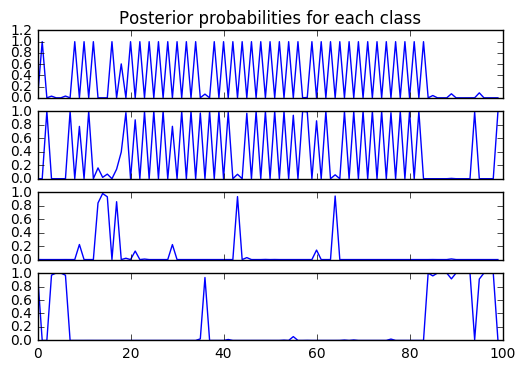

In [162]:
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot(np.arange(0,100), posterior[:100, 0])
axarr[0].set_title('Posterior probabilities for each class')
axarr[1].plot(np.arange(0,100), posterior[:100, 1])
axarr[2].plot(np.arange(0,100), posterior[:100, 2])
axarr[3].plot(np.arange(0,100), posterior[:100, 3])

plt.show()

In [6]:
# Credit to: 
# http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/
def plot_cov_ellipse(cov, pos, volume=.5, ax=None, fc='none', ec=[0,0,0], a=1, lw=1):
    """
    Plots an ellipse enclosing *volume* based on the specified covariance
    matrix (*cov*) and location (*pos*). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        volume : The volume inside the ellipse; defaults to 0.5
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
    """

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)

### Implementation of the K-means algorithm

In [7]:
class K_means:
    
    def __init__(self, k=4, n_dims=2):
        self.k = k
        self.n_dims = n_dims
        
    def train(self, train_data):
        # Initialize the cluster means
        self.means = np.random.rand(self.k, self.n_dims) * np.max(train_data, axis=0)
        n_iter = 0
        
        # Matrix where each row is a z_n assignment vector associated with a data point
        old_Z = np.zeros(shape=(train_data.shape[0], self.k))
        self.Z = np.zeros(shape=(train_data.shape[0], self.k))
        
        while(not self._converged(old_Z, n_iter)):
            old_Z = np.array(self.Z)
            self.Z = np.zeros(shape=(train_data.shape[0], self.k))
            
            # First phase, we evaluate the value of the latent cluster assignment variables
            for i, train_point in enumerate(train_data):                
                distances = np.linalg.norm(self.means - train_point, axis=1)**2
                self.Z[i][np.argmin(distances)] = 1 
            
            # Second phase, the values of the cluster means are computed
            self.means = self.Z.T.dot(train_data) / np.sum(self.Z.T, axis=1).reshape(self.k, 1)
            
            n_iter += 1
        
    def assign_cluster(self, data):
        
        # Will hold the cluster that each data point belongs to
        clusters = np.zeros(data.shape[0], dtype=int)
        
        for i, x in enumerate(data):            
            distances = np.linalg.norm(self.means - x, axis=1)**2
            clusters[i] = np.argmin(distances)
        
        return clusters
            
    
    # Helper function that checks the convergence of the K-means algorithm
    def _converged(self, old_Z, n_iter):
        if n_iter == 0:
            return False
        elif np.array_equal(old_Z, self.Z):
            return True
        else:
            return False

# EM algorithm to learn parameters of the model

In [8]:
class EM_HMM:
    
    def __init__(self, k=4, n_dims=2):
        self.k = k
        self.n_dims = n_dims
        
    def train(self, train_data, means, clusters, MAX_ITER = 100):
        # We start off by initializing our gaussian mixture parameters with the parameters given to us
        self.means = means
        self.covs = [np.eye(self.n_dims)] * self.k
        
        # compute the sample covariance of each cluster
        for i in xrange(self.k):
            self.covs[i] = np.cov(train_data[np.where(clusters==i)[0],:], rowvar=False) 

        # posterior probabilities or the weights N x K matrix
        self.taus = np.zeros(shape=(train_data.shape[0], self.k))
        self.pi = np.bincount(clusters) / clusters.shape[0]        
        n_iter = 0
        
        while(n_iter < MAX_ITER):            
            # E step
            for i in xrange(self.k):
                self.taus[:, i] = self.pi[i] * mv_normal.pdf(train_data, self.means[i], self.covs[i], True)
            
            # normalize the taus to get posterior probabilities
            self.taus = (self.taus.T / np.sum(self.taus, axis=1)).T
            
            # M step            
            # Compute the new means and covariance matrices
            for i in xrange(self.k):
                tau_sum = np.sum(self.taus[:, i])
                
                # First the mean for cluster i
                self.means[i] = (np.sum(self.taus[:, i].reshape(self.taus.shape[0], 1) * train_data, axis=0) / tau_sum)
                
                distance = train_data - self.means[i]
                self.covs[i] = (distance.T.dot(self.taus[:, i].reshape(self.taus.shape[0], 1) * distance) / tau_sum)
                self.pi[i] = tau_sum / train_data.shape[0]

                n_iter += 1
    
    def assign_cluster(self, data):
        taus = np.zeros(shape=(data.shape[0], self.k))
        for i in xrange(self.k):
                taus[:, i] = self.pi[i] * mv_normal.pdf(data, self.means[i], self.covs[i], True)
                
        clusters = np.zeros(data.shape[0], dtype=int)
        for i, x in enumerate(data):
            clusters[i] = np.argmax(taus[i, :])
        return clusters
    
    def normalized_log_likelihood(self, data):
        like = np.zeros(shape=(data.shape[0], self.k))
        for i in xrange(self.k):
                like[:, i] = self.pi[i] * mv_normal.pdf(data, self.means[i], self.covs[i], True)
        
        loglike = np.log(np.sum(like, axis=1))
        loglike = np.sum(loglike) / data.shape[0]
        
        return loglike
                

In [9]:
kmeans = K_means(k=4)
kmeans.train(train_data)
means = kmeans.means
clusters = kmeans.assign_cluster(train_data)

gmm = EM_GMM(k=4)
gmm.train(train_data, means, clusters, MAX_ITER=2000)

In [13]:
gmm.means

array([[ 3.97793025,  3.77333059],
       [-3.06196072, -3.53454048],
       [-2.03436695,  4.17258596],
       [ 3.80070949, -3.79729742]])

# Viterbi decoding algorithm